In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
df=pd.read_csv('/content/drive/MyDrive/Dataset/water-treatment.data', sep=',',header=None).to_numpy()
df.shape

(527, 39)

In [4]:
# Clear data
df = np.delete(df, 0, 1)

df[df == '?'] = '0.0'
df = df.astype(float)

df

array([[4.4101e+04, 1.5000e+00, 7.8000e+00, ..., 7.9400e+01, 8.7300e+01,
        9.9600e+01],
       [3.9024e+04, 3.0000e+00, 7.7000e+00, ..., 7.9500e+01, 9.2100e+01,
        1.0000e+02],
       [3.2229e+04, 5.0000e+00, 7.6000e+00, ..., 7.5800e+01, 8.8700e+01,
        9.8500e+01],
       ...,
       [3.2922e+04, 3.0000e-01, 7.4000e+00, ..., 7.7100e+01, 8.8900e+01,
        9.9000e+01],
       [3.2190e+04, 3.0000e-01, 7.3000e+00, ..., 8.7000e+01, 8.9500e+01,
        9.9800e+01],
       [3.0488e+04, 2.1000e-01, 7.5000e+00, ..., 8.1700e+01, 8.6400e+01,
        0.0000e+00]])

In [5]:
def distance(p1, p2):
    return math.sqrt(np.sum((p1 - p2)**2))

In [6]:
## k-means++
import random as rd
import math

def calculate_centroid_distance(item, centroids):
    d = float("inf")
    for j in range(len(centroids)):
        tmp = distance(item, centroids[j])
        d = min(d, tmp)
    return d

# Init centroids
def initialize(data, k):
    centroids = []
    row_size = data.shape[0]
    centroids.append(data[np.random.randint(row_size), :])

    for centroid in range(k - 1):
        centroids_dist = []
        for row in range(row_size):
            centroids_dist.append(
                calculate_centroid_distance(
                    data[row, :],
                    centroids
                )
            )

        centroids_dist = np.array(centroids_dist)
        centroids.append(data[np.argmax(centroids_dist), :])
    return centroids

# Move centroid
def update_centroids_mean(n, centroids, item):
    for i in range(len(centroids)):
        m = centroids[i]
        m = (m*(n-1)+item[i])/float(n)
        centroids[i] = round(m, 3)

    return centroids

# Classify an item with given centroids
def classify_item(centroids, item):
    distanses = np.array([distance(item, c) for c in centroids])
    return distanses.argmin()

# Run k-means++ algorithm
def fit_centroids(k, items):
    item_cluster = [0] * len(items)

    centroids = initialize(items, k)
    clusters_width = [0]*len(centroids)

    round_number = 0
    is_cluster_changed = True

    while round_number < 10000 and is_cluster_changed:
        for i in range(len(items)):
            cluster_idx = classify_item(centroids, items[i])

            clusters_width[cluster_idx] += 1
            centroids[cluster_idx] = update_centroids_mean(
                clusters_width[cluster_idx],
                centroids[cluster_idx],
                items[i]
            )

            if cluster_idx != item_cluster[i]:
                is_cluster_changed = False
            item_cluster[i] = cluster_idx
        round_number = round_number + 1

    return centroids

def divide_into_clusters(centroids, items):
    clusters = [[] for _ in range(len(centroids))]

    for item in items:
        index = classify_item(centroids, item)
        clusters[index].append(item)

    return clusters

centroids_final = fit_centroids(2, df)
cluters = divide_into_clusters(centroids_final, df)

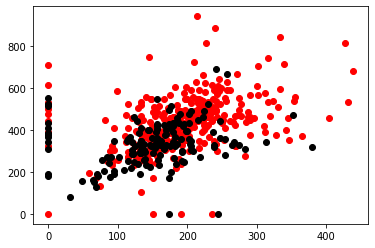

In [7]:
import matplotlib.pyplot as plt
plt.scatter(np.array(cluters[0])[:,3] , np.array(cluters[0])[:,4] , color = 'red')
plt.scatter(np.array(cluters[1])[:,3] , np.array(cluters[1])[:,4] , color = 'black')

plt.show()

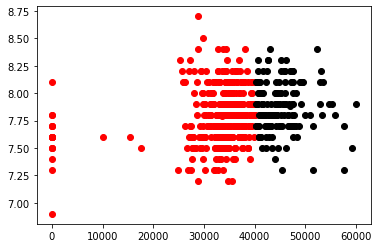

In [8]:
plt.clf()
plt.scatter(np.array(cluters[0])[:,0] , np.array(cluters[0])[:,2] , color = 'red')
plt.scatter(np.array(cluters[1])[:,0] , np.array(cluters[1])[:,2] , color = 'black')

plt.show()

In [9]:
# dbscan

# Find epsilon region of element 'p'. 
# Returns a boolean mask where elements in region of 'p' is labeled with True  
def region_query (p, eps, X):
    _, dim = X.shape
    assert (p.shape == (dim,)) or (p.shape == (1, dim)) or (p.shape == (dim, 1))
    
    region = []
    for index in range(len(X)):
      region.append(False)

    for index in range(len(X)):
      d = distance(X[index], p)
      if d <= eps:
        region[index] = True

    return np.array(region)

# Returns an array with indiexes of neighbors by the given mask 'y'
def index_set (y):
    assert len (y.shape) == 1

    true_indexes = set()

    for neighbor_index in range(len(y)):
      if y[neighbor_index] == True:
        true_indexes.add(neighbor_index)
        
    return true_indexes

# Reurns an array of neighbors for all elements in dataset
def find_neighbors (eps, X):
    m, d = X.shape
    neighbors = []
    
    for index in range(len(X)):
        neighbors.append(set())
    
    for index in range(len(X)):
        element_region = region_query(X[index], eps, X)
        element_neighbors = index_set(element_region)
        neighbors[index] = element_neighbors

    assert len (neighbors) == m
    return neighbors

# Returns a set of indices of core points in dataset
def find_core_points (s, neighbors):
    assert type (neighbors) is list
    assert all ([type (n) is set for n in neighbors])
    
    core_set = set ()
    
    for index in range(len(neighbors)):
      if len(neighbors[index]) >= s:
        core_set.add(index)

    return core_set

# Traverse all dataset and divide it into classes
def expand_cluster (p, neighbors, core_set, visited, assignment):
    assert (p in core_set) and (p in visited) and (p in assignment)
    
    reachable = set (neighbors[p])
    while reachable:
        q = reachable.pop ()

        if q in visited:
          continue
        
        if q not in visited:
          assignment[q] = assignment[p]
          
        if q not in visited:
          visited.add(q)

        if q in core_set:
          reachable |= neighbors[q]

# Run dbscan algorithm
def dbscan (eps, s, X):
    clusters = []
    point_to_cluster = {}
    
    neighbors = find_neighbors (eps, X)

    core_set = find_core_points (s, neighbors)
    
    assignment = {}
    next_cluster_id = 0

    visited = set ()
    for i in core_set:
        if i not in visited:
            visited.add (i)
            assignment[i] = next_cluster_id
            expand_cluster (i, neighbors, core_set,
                            visited, assignment)
            next_cluster_id += 1

    print('Number of clusters:')
    print(next_cluster_id)

    return assignment, core_set

assignment, core_set = dbscan (6000, 13, df)
print(assignment)
print(core_set)

Number of clusters:
2
{0: 0, 1: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 0, 128: 0, 129: 0, 130: 0, 131: 0, 132: 0, 133: 0, 134: 0, 135: 0, 136: 0, 137: 0, 13

In [10]:
def create_class(labels, class_id, X):
  class_elements = []
  for element_index, label in labels.items():
    if label == class_id:
      class_elements.append (X[element_index])

  return class_elements

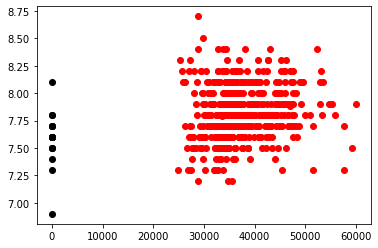

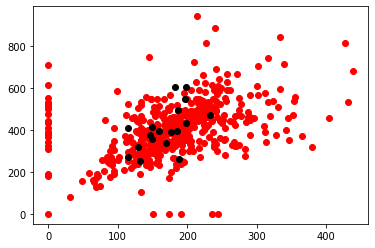

In [11]:
class1 = create_class(assignment, 0, df)
class2 = create_class(assignment, 1, df)
# class3 = create_class(assignment, 2, df)

plt.clf()
plt.scatter(np.array(class1)[:,0] , np.array(class1)[:,2] , color = 'red')
plt.scatter(np.array(class2)[:,0] , np.array(class2)[:,2] , color = 'black')
# plt.scatter(np.array(class3)[:,0] , np.array(class3)[:,2] , color = 'yellow')
plt.show()

plt.clf()
plt.scatter(np.array(class1)[:,3] , np.array(class1)[:,4] , color = 'red')
plt.scatter(np.array(class2)[:,3] , np.array(class2)[:,4] , color = 'black')
# plt.scatter(np.array(class3)[:,5] , np.array(class3)[:,4] , color = 'yellow')
plt.show()